## Data Analysis

In [1]:
import json
import os
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
DATA_PATH = 'iflytek_public'

In [3]:
def read_file(file_name):
    li = []
    with open(os.path.join(DATA_PATH, file_name), 'rb') as f:
        for line in f.readlines():
            li.append(json.loads(line))
    return li

In [4]:
train = read_file('train.json')
# test = read_file('test.json')
labels = read_file('labels.json')
test = read_file('dev.json')

In [5]:
train_df = pd.DataFrame.from_records(train)
test_df = pd.DataFrame.from_records(test)
labels_df = pd.DataFrame.from_records(labels, index='label')

In [10]:
print(f'Number of training data: {len(train_df)}')
print(f'Number of testing data: {len(test_df)}')

Number of training data: 12133
Number of testing data: 2599


In [6]:
train_df = pd.merge(train_df, labels_df, left_on='label', right_index=True)[['label', 'sentence', 'label_des_x']]
train_df = train_df.rename({
    'label_des_x': 'label_name',
}, axis=1)

test_df = pd.merge(test_df, labels_df, left_on='label', right_index=True)[['label', 'sentence', 'label_des_x']]
test_df = test_df.rename({
    'label_des_x': 'label_name',
}, axis=1)

Text(0, 0.5, 'Number of classes')

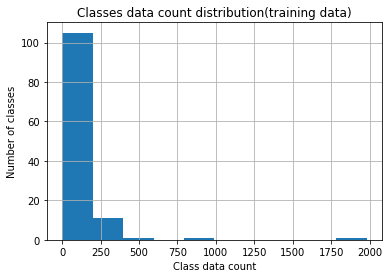

In [7]:
train_df.groupby('label').count()[['sentence']].sort_index().hist()
plt.title('Classes data count distribution(training data)')
plt.xlabel('Class data count')
plt.ylabel('Number of classes')

Text(0, 0.5, 'Number of classes')

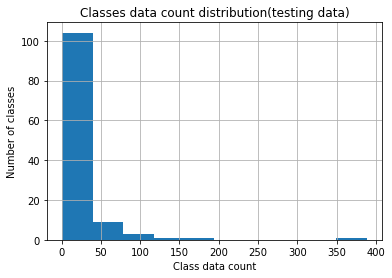

In [8]:
test_df.groupby('label').count()[['sentence']].sort_index().hist()
plt.title('Classes data count distribution(testing data)')
plt.xlabel('Class data count')
plt.ylabel('Number of classes')

Text(0, 0.5, 'Class index')

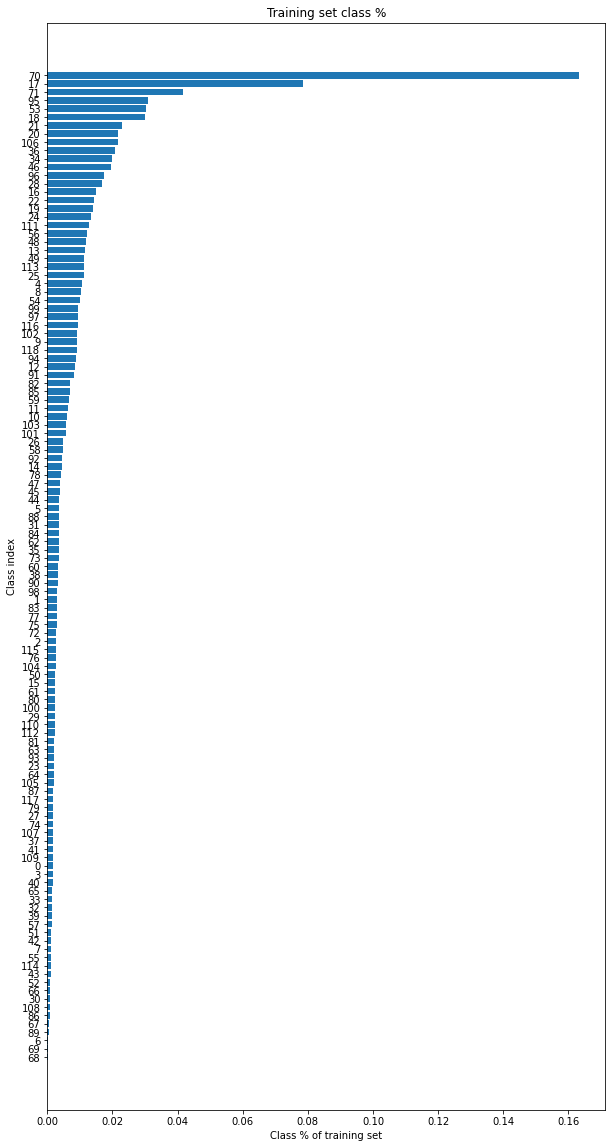

In [105]:
train_gb = train_df.groupby('label').count().sort_values('sentence', ascending=True).reset_index()
train_gb = pd.merge(train_gb, labels_df, left_on='label', right_index=True)


plt.figure(figsize=(10,20))
plt.barh(y=train_gb['label'], width=train_gb['sentence']/len(train_df))
plt.title('Training set class %')
plt.xlabel('Class % of training set')
plt.ylabel('Class index')

Text(0, 0.5, 'Class index')

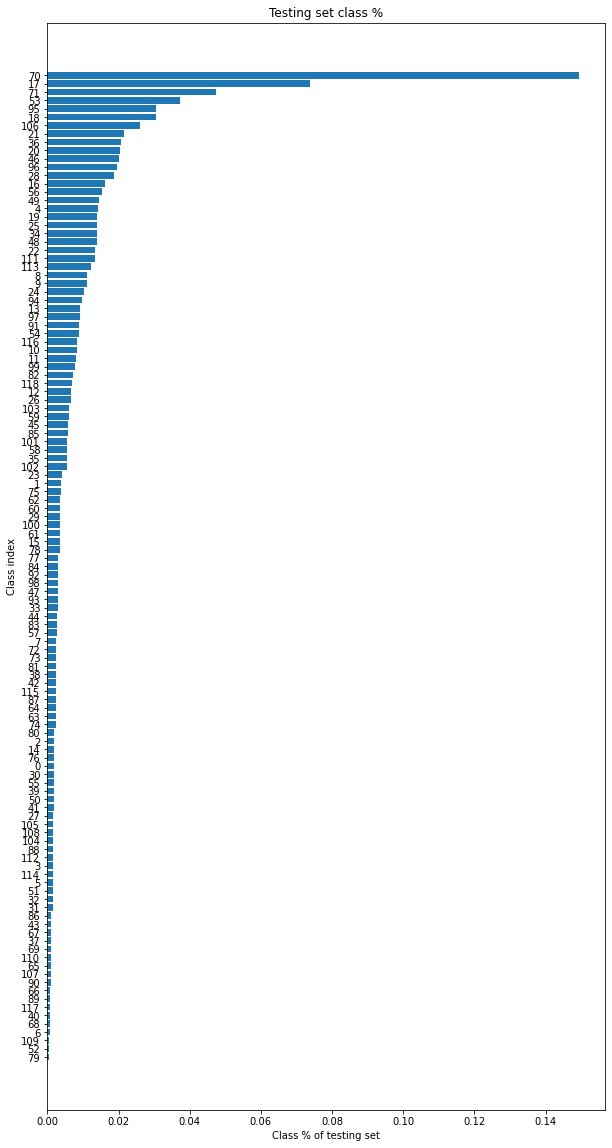

In [106]:
test_gb = test_df.groupby('label').count().sort_values('sentence', ascending=True).reset_index()
test_gb = pd.merge(test_gb, labels_df, left_on='label', right_index=True)


plt.figure(figsize=(10,20))
plt.barh(y=test_gb['label'], width=test_gb['sentence']/len(test_df))
plt.title('Testing set class %')
plt.xlabel('Class % of testing set')
plt.ylabel('Class index')

In [8]:
n = 10

topN_train_class = set(train_df.groupby('label').count()[['label_des']].sort_values('label_des', ascending=False)[:n].index)
topN_test_class = set(test_df.groupby('label').count()[['label_des']].sort_values('label_des', ascending=False)[:n].index)
overlap = round(len(topN_train_class.intersection(topN_test_class))/len(topN_train_class), 3)

print('{}% of the top {} most donimant classes in train and test set are the same.'.format(overlap*100, n))

100.0% of the top 10 most donimant classes in train and test set are the same.


As we can see from the above result, the training set and testing set are sharing a very similar distribution.

## Length of sentences

In [18]:
train_df['sentence_length'] = train_df['sentence'].apply(len)
test_df['sentence_length'] = test_df['sentence'].apply(len)

88.2% of the sentences are shorter than 512 characters


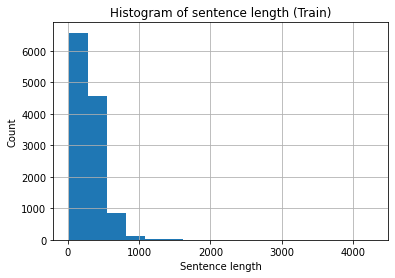

In [19]:
train_df.sort_values('sentence_length', ascending=False)['sentence_length'].hist(bins=16)
plt.title('Histogram of sentence length (Train)')
plt.xlabel('Sentence length')
plt.ylabel('Count')

short_sentence_perc = round(100*len(train_df[train_df['sentence_length'] < 512])/len(train_df), 1)
print(f'{short_sentence_perc}% of the sentences are shorter than 512 characters')

88.2% of the sentences are shorter than 512 characters


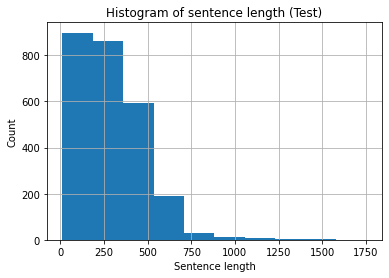

In [20]:
test_df.sort_values('sentence_length', ascending=False)['sentence_length'].hist()
plt.title('Histogram of sentence length (Test)')
plt.xlabel('Sentence length')
plt.ylabel('Count')

short_sentence_perc = round(100*len(test_df[test_df['sentence_length'] < 512])/len(test_df), 1)
print(f'{short_sentence_perc}% of the sentences are shorter than 512 characters')

As we can observe from the above histograms, a BERT model is able to handle almost 90% of the data. 

## Base model

In [48]:
!pip install jieba

In [49]:
import jieba
from tqdm import tqdm
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import numpy as np
from sklearn.linear_model import SGDClassifier

In [50]:
def get_tokens(sentence_list, stop_words=[]):
    tokens = []

    for sentence in tqdm(sentence_list):
        token = [tok for tok in jieba.cut(sentence, cut_all=False) if tok not in stop_words and not tok.isascii()]
        tokens.append(token)

    return tokens

def get_stopwords():
    f = open('data/stopwords.dat', "r")
    content_lines = f.readlines()
    f.close()
    for i in range(len(content_lines)):
        content_lines[i] = content_lines[i].rstrip("\n")
    return set(content_lines)

In [51]:
stopwords = get_stopwords()

In [52]:
train_df['tokens'] = get_tokens(train_df['sentence'], stopwords)
test_df['tokens'] = get_tokens(test_df['sentence'], stopwords)

100%|████████████████████████████████████████████████████████████████████████████████████████| 2599/2599 [00:01<00:00, 2130.63it/s]


In [53]:
model_train_df, valid_df = train_test_split(train_df, test_size=0.3)

In [54]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x)
vectorizer.fit(model_train_df['tokens'])
print(len(vectorizer.get_feature_names_out()))

51574


In [55]:
train_tokens = set(vectorizer.get_feature_names())

/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
valid_tokens = []
for li in valid_df['tokens']:
    valid_tokens.extend(li)

valid_tokens = set(valid_tokens)

test_tokens = []
for li in test_df['tokens']:
    test_tokens.extend(li)

test_tokens = set(test_tokens)

In [57]:
valid_token_coverage = len(valid_tokens.intersection(train_tokens))/len(valid_tokens)
test_token_coverage = len(test_tokens.intersection(train_tokens))/len(test_tokens)

print('The coverage for valid set tokens is {}'.format(round(valid_token_coverage, 3)))
print('The coverage for test set tokens is {}'.format(round(test_token_coverage, 3)))

The coverage for valid set tokens is 0.708
The coverage for test set tokens is 0.739


In [58]:
train_x = vectorizer.transform(model_train_df['tokens'])
train_y = model_train_df['label']

valid_x = vectorizer.transform(valid_df['tokens'])
valid_y = valid_df['label']

test_x = vectorizer.transform(test_df['tokens'])
test_y = test_df['label']

In [68]:
clf = SGDClassifier()

parameters = {
    'loss': ['hinge'], #['hinge',  'log_loss', 'log']
    'penalty': ['l2'], # ['l1', 'l2']
    'alpha': [1e-5], # [1e-5, 1e-3]
    'max_iter': [2000], #[500, 1000, 2000]
}
# clf = GridSearchCV(clf, parameters)

In [69]:
clf.fit(train_x, train_y)

SGDClassifier()

In [70]:
valid_prediction = base_model.predict(valid_x)
print('Accuracy for validation set:')
print(np.mean(valid_prediction == valid_y))

Accuracy for validation set:
0.5554945054945055


In [71]:
print(classification_report(valid_y, valid_prediction))

              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.39      0.50      0.44        14
          10       0.35      0.33      0.34        21
         100       0.00      0.00      0.00         8
         101       0.68      0.50      0.58        26
         102       0.47      0.41      0.44        34
         103       0.30      0.38      0.33        16
         104       0.67      0.33      0.44        12
         105       0.67      0.44      0.53         9
         106       0.42      0.54      0.47        87
         107       0.00      0.00      0.00         7
         108       0.33      0.33      0.33         3
         109       0.50      0.10      0.17        10
          11       0.18      0.10      0.12        21
         110       1.00      0.08      0.15        12
         111       0.42      0.49      0.45        45
         112       0.00      0.00      0.00         6
         113       0.53    

/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
test_prediction = clf.predict(test_x)
print('Accuracy for testing set:')
print(np.mean(test_prediction == test_y))

Accuracy for testing set:
0.5625240477106579


In [73]:
print(classification_report(test_y, test_prediction))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.56      0.50      0.53        10
          10       1.00      0.18      0.31        22
         100       0.00      0.00      0.00         9
         101       0.60      0.43      0.50        14
         102       0.18      0.21      0.19        14
         103       0.41      0.44      0.42        16
         104       0.00      0.00      0.00         4
         105       0.00      0.00      0.00         4
         106       0.51      0.54      0.52        68
         107       0.00      0.00      0.00         3
         108       0.00      0.00      0.00         4
         109       0.00      0.00      0.00         1
          11       0.22      0.10      0.13        21
         110       0.00      0.00      0.00         3
         111       0.40      0.40      0.40        35
         112       0.25      0.25      0.25         4
         113       0.42    

/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kingf/pyvenv/python_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A simple linear model on tf-idf data can already produce a result that is comparable to a BERT classifier (Please refer to BERT result)

## BERT Model result analysis

After training, a result.json will be save in src/exp_dump. This part is for analysis the performance of model during training

In [99]:
with open('exp_dump/bert_result.json', 'rb') as f:
    bert_result = json.load(f)

with open('exp_dump/bert_cnn_result.json', 'rb') as f:
    bert_cnn_result = json.load(f)

Text(0, 0.5, 'Accuracy')

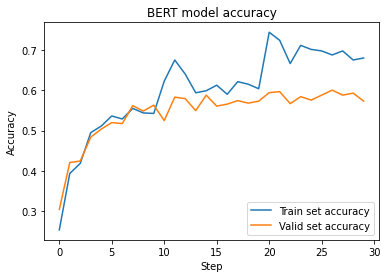

In [100]:
plt.plot(bert_result['train_acc'])
plt.plot(bert_result['valid_acc'])
plt.title('BERT model accuracy')
plt.legend([
    'Train set accuracy',
    'Valid set accuracy'
])
plt.xlabel('Step')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

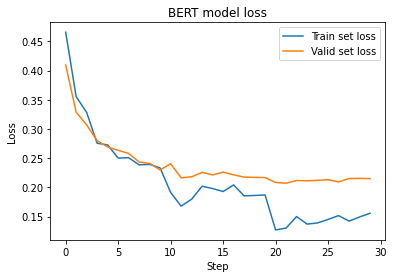

In [101]:
plt.plot(bert_result['train_loss'])
plt.plot(bert_result['valid_loss'])
plt.title('BERT model loss')
plt.legend([
    'Train set loss',
    'Valid set loss'
])
plt.xlabel('Step')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

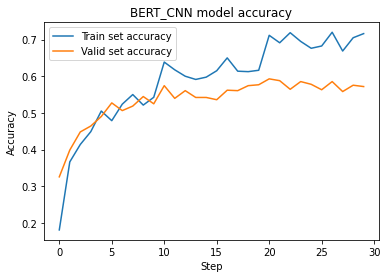

In [102]:
plt.plot(bert_cnn_result['train_acc'])
plt.plot(bert_cnn_result['valid_acc'])
plt.title('BERT_CNN model accuracy')
plt.legend([
    'Train set accuracy',
    'Valid set accuracy'
])
plt.xlabel('Step')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

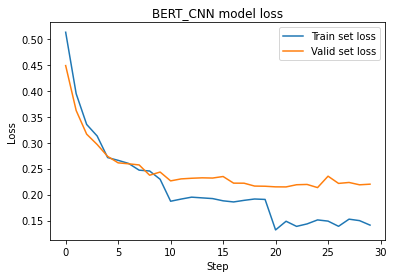

In [103]:
plt.plot(bert_cnn_result['train_loss'])
plt.plot(bert_cnn_result['valid_loss'])
plt.title('BERT_CNN model loss')
plt.legend([
    'Train set loss',
    'Valid set loss'
])
plt.xlabel('Step')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

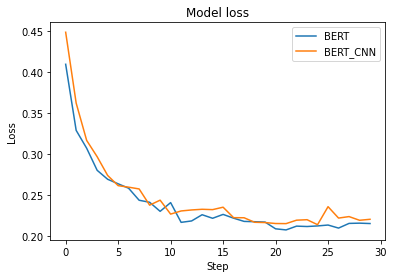

In [104]:
plt.plot(bert_result['valid_loss'])
plt.plot(bert_cnn_result['valid_loss'])
plt.title('Model loss')
plt.legend([
    'BERT',
    'BERT_CNN'
])
plt.xlabel('Step')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

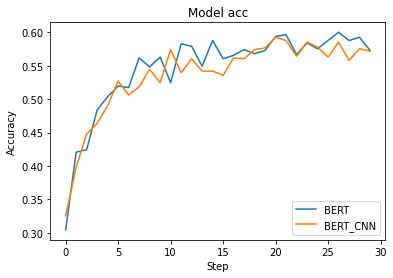

In [105]:
plt.plot(bert_result['valid_acc'])
plt.plot(bert_cnn_result['valid_acc'])
plt.title('Model acc')
plt.legend([
    'BERT',
    'BERT_CNN'
])
plt.xlabel('Step')
plt.ylabel('Accuracy')